In [263]:
import numpy as np
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [264]:
dataframe = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
dataframe.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Number of Sarcastic Texts: 13634
Number of Non Sarcastic Texts: 14985


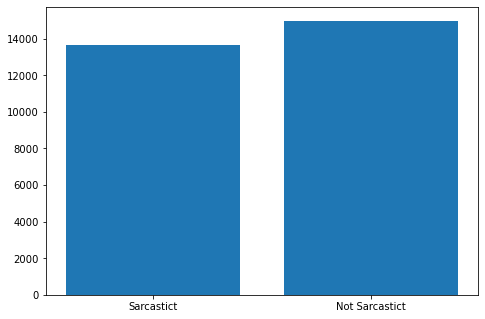

In [265]:
is_sarcastic_texts =[]
not_is_sarcastic_texts =[]
for index, row in dataframe.iterrows():
    if row['is_sarcastic'] == 1:
        is_sarcastic_texts.append(row)
    else:
        not_is_sarcastic_texts.append(row)

print("Number of Sarcastic Texts:",len(is_sarcastic_texts))
print("Number of Non Sarcastic Texts:",len(not_is_sarcastic_texts))

""" Plot the counts of sentiment and compare"""
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiments = ['Sarcastict','Not Sarcastict']
number = [len(is_sarcastic_texts),len(not_is_sarcastic_texts)]
ax.bar(sentiments,number)
plt.show() 

In [266]:
from torchtext import data
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

In [267]:
import torchtext
TRAIN_JSON = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'

fields = {'headline': ('text', TEXT), 'is_sarcastic': ('label', LABEL)}

dataset = torchtext.data.TabularDataset(path=TRAIN_JSON,format='json',fields=fields)
print(dataset)

(train_data,valid_data) = dataset.split(split_ratio=[0.8,0.1])

"""train_data, valid_data = d.split(random_state = random.seed(SEED))"""


print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(valid_data)}')

Number of training examples: 25439
Number of testing examples: 3180


In [268]:

MAX_VOCAB_SIZE = 25657

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [269]:
print(len(TEXT.vocab))
print(len(LABEL.vocab))
print(LABEL.vocab.stoi)
print(TEXT.vocab.stoi[TEXT.pad_token])

25657
2
defaultdict(None, {0: 0, 1: 1})
1


In [270]:
print(vars(train_data.examples[6]))

{'text': ['listen', 'up', '!', 'my', 'favorite', 'americana', 'discoveries', 'of', '2014'], 'label': 0}


In [271]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE, sort_within_batch = True,
    sort_key = lambda x: len(x.text),
    device = device)

In [272]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [273]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [1,2,3]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [274]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,626,301 trainable parameters


In [275]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.1897,  0.0500,  0.1908,  ..., -0.3980,  0.4765, -0.1598],
        ...,
        [ 0.2272, -1.8329, -1.2672,  ..., -0.8241,  1.3403,  0.9017],
        [ 0.3542,  1.3837,  0.5389,  ...,  0.4686,  0.6476, -0.8975],
        [-0.3223, -0.8340, -0.1413,  ...,  0.6861, -0.0195, -0.2755]])

In [276]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [277]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [278]:
model

CNN(
  (embedding): Embedding(25657, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [279]:
device

device(type='cpu')

In [280]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [281]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [282]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [283]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [284]:
N_EPOCHS = 5

best_valid_loss = float('inf')
history=[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    result = {'val_loss': valid_loss, 'val_acc': valid_acc}
    history.append(result)

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 0.515 | Train Acc: 74.43%
	 Val. Loss: 0.372 |  Val. Acc: 84.96%
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.315 | Train Acc: 86.92%
	 Val. Loss: 0.309 |  Val. Acc: 86.62%
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.227 | Train Acc: 91.05%
	 Val. Loss: 0.298 |  Val. Acc: 87.75%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.159 | Train Acc: 94.03%
	 Val. Loss: 0.336 |  Val. Acc: 87.62%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.111 | Train Acc: 96.03%
	 Val. Loss: 0.335 |  Val. Acc: 87.87%


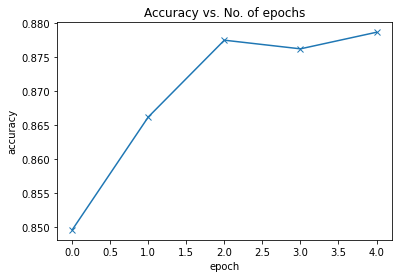

In [285]:
"""Plot the loss and accuraccy"""

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

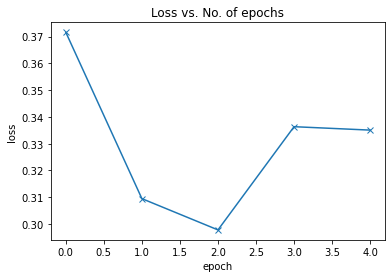

In [286]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [287]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    print(prediction.item())
    pred = round(prediction.item())
    if pred == 1:
        return "Sarcastic"
    else:
        return "Not Sarcastic"

In [288]:
predict_sentiment(model, "product of the day: happy man #wine tool who's it's the #weekend? time to open up &amp; drink up!")

0.02477968856692314


'Not Sarcastic'

In [289]:
predict_sentiment(model, "thirtysomething scientists unveil doomsday clock of hair loss")

0.998769223690033


'Sarcastic'